In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
plt.rcParams['figure.figsize'] = (11.0, 7.0)

In [2]:
RESULTS = Path("../results")

In [3]:
gt = pd.read_table(RESULTS / "glycosyltransferases.txt")
variants = pd.read_table(RESULTS / "gt_variants.txt.gz", compression="gzip")

In [4]:
exon_variants = variants[variants["exon"] > 0]

Confirm that we have exon variants.

In [5]:
exon_variants["consequenceTerms"].value_counts()

3_prime_UTR_variant                          13580
missense_variant                              6904
synonymous_variant                            4146
5_prime_UTR_variant                           2538
stop_gained                                    205
missense_variant,splice_region_variant         153
splice_region_variant,synonymous_variant        93
frameshift_variant                              27
splice_region_variant,5_prime_UTR_variant       19
inframe_deletion                                13
start_lost                                      12
stop_retained_variant                            8
stop_lost                                        6
inframe_insertion                                4
stop_gained,splice_region_variant                3
protein_altering_variant                         1
start_lost,5_prime_UTR_variant                   1
frameshift_variant,stop_retained_variant         1
Name: consequenceTerms, dtype: int64

Mark synonymous variants.

In [6]:
exon_variants = exon_variants.assign(isSilent=exon_variants["consequenceTerms"].str.contains("synonymous_variant"))

Double check that we have marked correctly.

In [7]:
pd.crosstab(exon_variants["consequenceTerms"], exon_variants["isSilent"])

isSilent                                   False  True 
consequenceTerms                                       
3_prime_UTR_variant                        13580      0
5_prime_UTR_variant                         2538      0
frameshift_variant                            27      0
frameshift_variant,stop_retained_variant       1      0
inframe_deletion                              13      0
inframe_insertion                              4      0
missense_variant                            6904      0
missense_variant,splice_region_variant       153      0
protein_altering_variant                       1      0
splice_region_variant,5_prime_UTR_variant     19      0
splice_region_variant,synonymous_variant       0     93
start_lost                                    12      0
start_lost,5_prime_UTR_variant                 1      0
stop_gained                                  205      0
stop_gained,splice_region_variant              3      0
stop_lost                                      6      0
stop_retained_variant                          8      0
synonymous_variant                             0   4146

For every glycosyltransferase, count the number of synonymous and non-synonymous exon variants, and their ratio (proportion of synonymous variants).

In [8]:
props = []
for tid, group in exon_variants.groupby("transcriptId"):
    silent_count = group["isSilent"].sum()
    non_silent_count = (~group["isSilent"]).sum()
    prop = silent_count / (silent_count + non_silent_count)
    props.append({
        "transcriptId": tid,
        "silentExonVariantCount": silent_count,
        "nonSilentExonVariantCount": non_silent_count,
        "silentExonVariantProportion": prop
    })
df = pd.DataFrame(props)

In [9]:
df

nonSilentExonVariantCount  silentExonVariantCount  \
0                           74                      39   
1                           84                      34   
2                           47                      15   
3                          122                      31   
4                           84                      25   
5                           71                      33   
6                           40                       8   
7                            8                       0   
8                           23                      11   
9                           66                      30   
10                          36                       8   
11                         125                      46   
12                         185                      42   
13                          62                      17   
14                          98                      12   
15                          59                      19   
16                          75                      15   
17                         161                       9   
18                          58                      38   
19                         101                       3   
20                         120                      13   
21                         194                      12   
22                         171                       6   
23                         189                      16   
24                          43                      10   
25                          23                       9   
26                          77                      34   
27                          20                      16   
28                          42                      11   
29                          42                      13   
..                         ...                     ...   
214                         52                      16   
215                        130                      37   
216                         36                      17   
217                         93                      10   
218                         75                      25   
219                         72                      14   
220                         80                      19   
221                         74                      20   
222                        229                      19   
223                         49                       8   
224                        181                      13   
225                         81                      24   
226                         47                      10   
227                        150                      13   
228                         66                      21   
229                        359                      13   
230                        150                      28   
231                         31                      19   
232                         72                      28   
233                         61                       8   
234                         51                      18   
235                         39                      11   
236                        543                       0   
237                         66                       9   
238                         53                       8   
239                          8                       3   
240                         40                      10   
241                         56                       7   
242                         24                      10   
243                        112                       6   

     silentExonVariantProportion     transcriptId  
0                       0.345133  ENST00000017003  
1                       0.288136  ENST00000026218  
2                       0.241935  ENST00000029410  
3                       0.202614  ENST00000035307  
4                       0.229358  ENST00000156626  
5                       0.317308  ENST00000164139  
6                       0.166667  ENST000001

In [10]:
gt = gt.merge(df, on="transcriptId")

Plot the distributions of proportions for GTs with and without an entry in http://orpha.net.

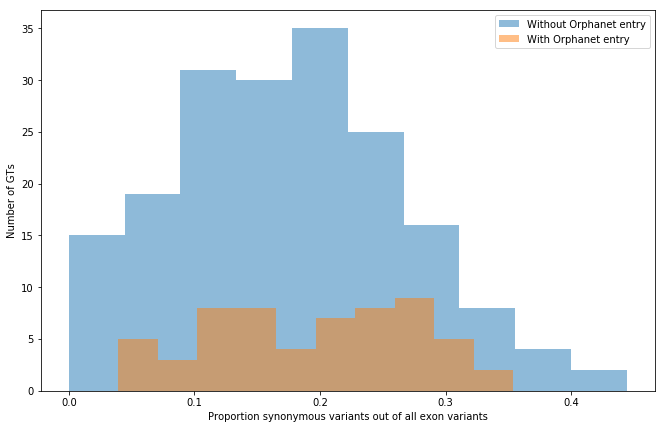

In [11]:
fig, ax = plt.subplots()

ax.hist(gt[gt["orphanet"].isnull()]["silentExonVariantProportion"], label="Without Orphanet entry", alpha=0.5)
ax.hist(gt[gt["orphanet"].notnull()]["silentExonVariantProportion"], label="With Orphanet entry", alpha=0.5)
ax.set(ylabel="Number of GTs", xlabel="Proportion synonymous variants out of all exon variants")
ax.legend();

Not much of a difference. Also Mann-Whitney _U_-test for difference in distribution between the two groups.

In [12]:
from scipy import stats

In [13]:
mwresult = stats.mannwhitneyu(gt[gt["orphanet"].notnull()]["silentExonVariantProportion"],
                              gt[gt["orphanet"].isnull()]["silentExonVariantProportion"])
mwresult

MannwhitneyuResult(statistic=4739.5, pvalue=0.064265609218104758)

In [14]:
print(f"p = {mwresult.pvalue}, no evidence for a difference.")

p = 0.06426560921810476, no evidence for a difference.
